In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from eff import flare_utils as ut
from flare.gp import GaussianProcess as gp
import os
import json
from flare.env import AtomicEnvironment
from flare.struc import Structure
from ase.io import read
from pathlib import Path

sns.set_style("white")
sns.set_context("talk")
colors_ = ['tab:red', 'gold', 'tab:green', 'tab:blue', 'tab:purple']
markers = ['o', 'v', 's', '*', 'X']

def pred_all(mgp, struc, cutoffs):
    nat = struc[0].nat
    pred_forces = np.zeros((len(struc)*nat, 3))
    pred_energies = np.zeros(len(struc))
    true_forces = np.zeros((len(struc)*nat, 3))
    true_energies = np.zeros(len(struc))
    force_var = np.zeros((len(struc)*nat))
    
    for j, s in enumerate(struc):
        try:
            true_forces[j*nat:(j+1)*nat, :] = s.forces
        except:
            true_forces[j*nat:(j+1)*nat, :] = None
            
        try:
            true_energies[j] = s.energy
        except:
            true_energies[j] = None

        for i in np.arange(nat):
            pred_forces[j*nat+i, :], v, __, en = mgp.predict(AtomicEnvironment(s, i, cutoffs))
            force_var[j*nat+i] = v**0.5
            pred_energies[j] += en
    return true_forces, pred_forces, true_energies, pred_energies, force_var

# Generate Data set

In [3]:
from eff import flare_utils as ut
from flare.struc import Structure

# Load xyz data
input_file =  "delta_silicon.xyz"
frames_ = read(input_file, index = ':')
    
# Wrap positions so rascal does not complain
for ff in frames_:
    ff.wrap(eps=1e-11)
energy_name = 'dft_energy'
force_name = 'dft_force'
virial_name = 'dft_virial'

tags = set()
for ff in frames_:
    tags.add(ff.info['config_type'])
print(tags)

# build a potential for diamond phase only
frames = []
for ff in frames_:
    if ff.info['config_type'] in ['amorph', 'bt', 'dia', 'liq', 'fcc', 'bcc', 'hcp', 'hex_diamond']:
        try:
            len(ff.info['dft_virial'])
            frames.append(ff)
        except KeyError:
            pass
        
zero_point_energy = -frames_[0].info['dft_energy']

frames_json = [Structure.from_ase_atoms(f) for f in frames]
dft_forces = [f.get_array('dft_force') for f in frames]
dft_energies = [f.info['dft_energy'] for f in frames]
delta_forces = [f.get_array('delta_forces') for f in frames]
delta_energies = [f.info['delta_energy'] for f in frames]

for i, f in enumerate(frames_json):
    f.forces = dft_forces[i]
    f.energy = dft_energies[i] + f.nat*zero_point_energy
ut.save_as_json(frames_json, "reduced_dft_silicon.json")

for i, f in enumerate(frames_json):
    f.forces = delta_forces[i]
    f.energy = delta_energies[i] + f.nat*zero_point_energy
ut.save_as_json(frames_json, "reduced_delta_silicon.json")

FileNotFoundError: [Errno 2] No such file or directory: '../data/Si_2018/delta_silicon.xyz'

# Check M-FFs

In [2]:
mgp, cutoffs = ut.load_mgp("/home/claudio/postdoc/integrated_potentials/data/Si_2018/mffs/mapped_model_100_3b_energy_True_opt_False_dft_data.json")
struct = ut.load_structures("/home/claudio/postdoc/integrated_potentials/data/Si_2018/reduced_dft_silicon.json")

In [3]:
nats = np.array([ss.nat for ss in struct])

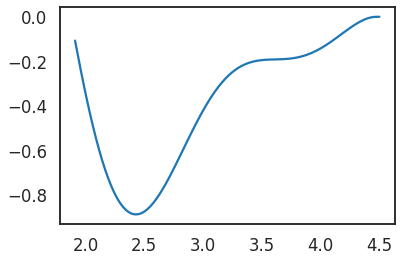

In [4]:
plt.plot(np.linspace(mgp.maps['twobody'].as_dict()['bounds'][0][0][0], mgp.maps['twobody'].as_dict()['bounds'][0][1][0], 102),
    mgp.maps['twobody'].as_dict()['maps'][0][0])
plt.show()

In [7]:
true_forces, pred_forces, true_energies, pred_energies, force_var = pred_all(mgp, struct, cutoffs)

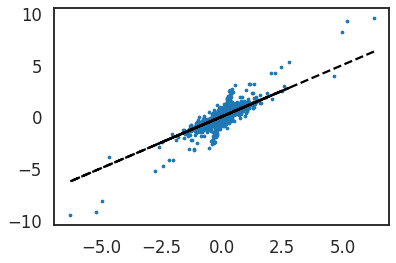

In [13]:
plt.scatter(true_forces, pred_forces, s= 5)
plt.plot(true_forces, true_forces, 'k--')
plt.show()